In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
sys.path.append('/glade/u/home/noahrose/ECCOv4-py/')
import ecco_v4_py as ecco
from adj_utils import load_output

import xarray as xr

from cartopy import crs as ccrs
from cartopy import feature as cfeature

In [2]:
depth = 250
qoi_name = '0-700m Temperature'
#suffix = '_v2'
suffix = ''

In [3]:
lonboundaries = np.array([-60, 20, 160]) #longitude boundaries
latboundaries = np.array([-48,-61])

In [4]:


hc_full = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_full_mask{suffix}.bin_1/')
hc_atl = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_Atl_mask{suffix}.bin_1/')
hc_pac = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_Pac_mask{suffix}.bin_1/')
hc_ind = load_output(f'/glade/work/noahrose/emu_so_hc/emu_adj_301_312_3_SO_T{depth}_Ind_mask{suffix}.bin_1/')

llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
llc_compact_to_faces: dims, llc  (1358, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (1358, 13, 90, 90)
llc_faces_to_tiles: data_ti

In [5]:
hc_arr = [hc_full,hc_atl,hc_pac,hc_ind]

In [6]:
labels = ['full','atl','pac','ind']

In [7]:
full_mask = np.fromfile('SO_T700_full_mask_v2.bin','>f4')
atl_mask = np.fromfile('SO_T700_Atl_mask_v2.bin','>f4')
pac_mask = np.fromfile('SO_T700_Pac_mask_v2.bin','>f4')
ind_mask = np.fromfile('SO_T700_Ind_mask_v2.bin','>f4')

In [8]:
normalize=False
weights = [full_mask.sum(),
           atl_mask.sum(),
           pac_mask.sum(),
           ind_mask.sum()]

if normalize == True:

    hc_arr = [hc_arr[i] / weights[i] for i in range(4)]

In [9]:
hc_rms_qnet = [((ds.qnet**2).sum(('lat','lon')))**0.5 for ds in hc_arr]

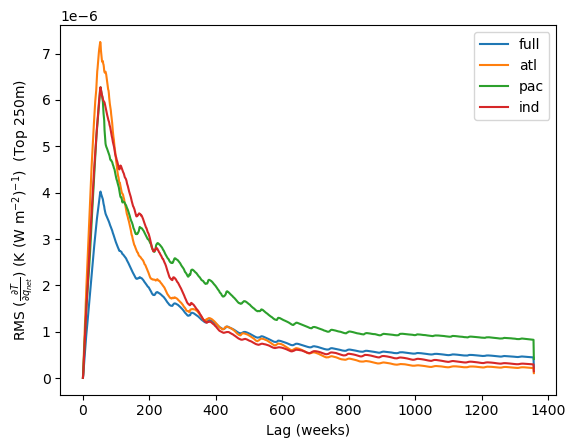

In [10]:
for i in range(4):
    plt.plot(hc_rms_qnet[i].lag,hc_rms_qnet[i],label=labels[i])
plt.legend()
plt.xlabel('Lag (weeks)')
plt.ylabel(r'RMS ($\frac{\partial T}{\partial q_{net}}$) (K (W m$^{-2}$)$^{-1}$)' + f'  (Top {depth}m)')
plt.savefig('figs/rms_qnet.png')

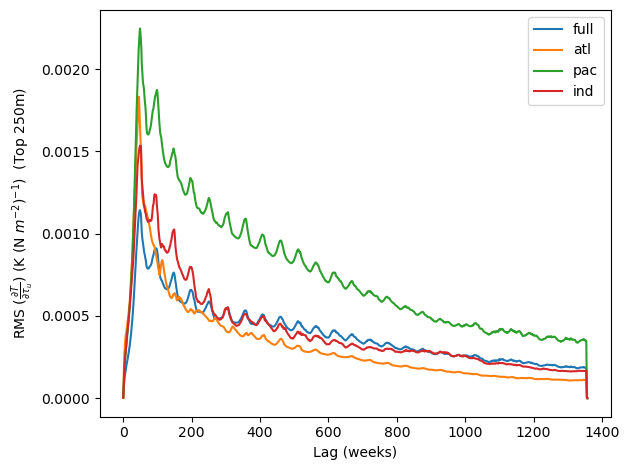

In [11]:
hc_rms_tauu = [((ds.tauu**2).sum(('lat','lon')))**0.5 for ds in hc_arr]

for i in range(4):
    plt.plot(hc_rms_tauu[i].lag,hc_rms_tauu[i],label=labels[i])
plt.legend()
plt.xlabel('Lag (weeks)')
plt.ylabel(r'RMS ($\frac{\partial T}{\partial \tau_{u}}$) (K (N $m^{-2}$)$^{-1}$)' +f'  (Top {depth}m)')
plt.tight_layout()
plt.savefig('figs/rms_tauu.png')

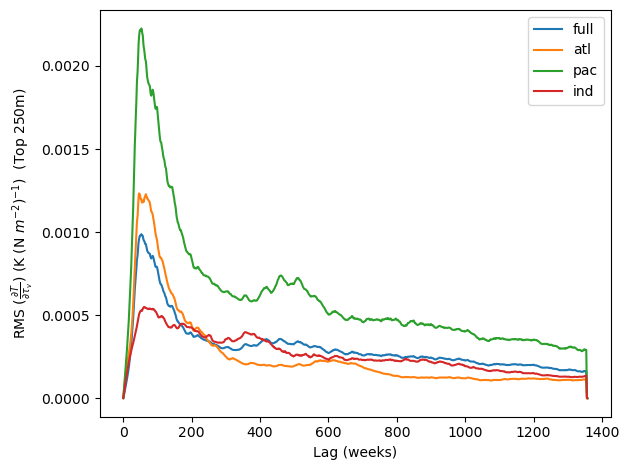

In [12]:
hc_rms_tauv = [((ds.tauv**2).sum(('lat','lon')))**0.5 for ds in hc_arr]

for i in range(4):
    plt.plot(hc_rms_tauv[i].lag,hc_rms_tauv[i],label=labels[i])
plt.legend()
plt.xlabel('Lag (weeks)')
plt.ylabel(r'RMS ($\frac{\partial T}{\partial \tau_{v}}$) (K (N $m^{-2}$)$^{-1}$)' + f'  (Top {depth}m)')
plt.tight_layout()
plt.savefig('figs/rms_tauv.png')

In [95]:
def plot_var(varname,lag,vmax):
    fig,axs = plt.subplots(2,2,subplot_kw={'projection':ccrs.Orthographic(0,-90)})
    for i,ax in enumerate(axs.flatten()):
        im = ax.pcolormesh(hc_arr[i].lon,hc_arr[i].lat,
                      hc_arr[i][varname].sel({'lag':lag}),
                      cmap='RdBu_r',
                      norm = colors.CenteredNorm(halfrange=vmax),
                        transform = ccrs.PlateCarree()
                     )
        plt.colorbar(im,ax=ax)
        ax.set_title(labels[i])
        ax.add_feature(cfeature.LAND,facecolor='k',zorder=10)
        ax.vlines(lonboundaries,-61,-48,color='k',lw=0.5,transform=ccrs.PlateCarree())
        ax.plot(hc_arr[i].lon,(np.ones(360)*latboundaries[:,np.newaxis]).T,
                '-k',lw=0.5,transform=ccrs.PlateCarree())
    plt.suptitle(f'Sensitivity of {qoi_name} to {varname} at lag {lag} weeks before 1/1/18')
    plt.savefig(f'figs/adj_{varname}_lag_{lag}.png')
    return()


()

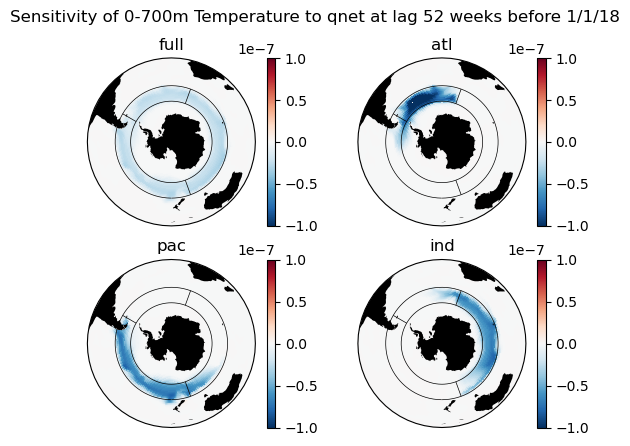

In [96]:
plot_var('qnet',52,1e-7)

()

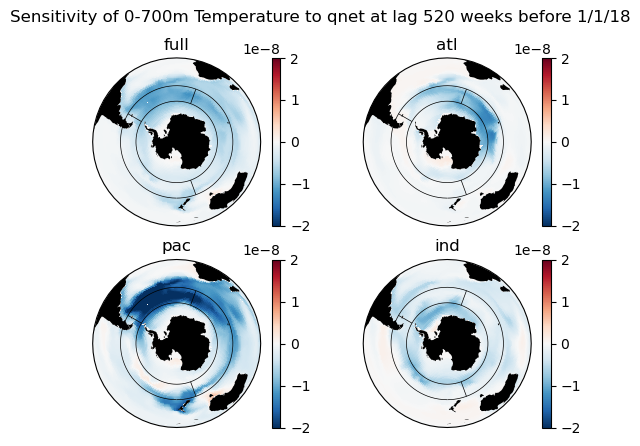

In [97]:
plot_var('qnet',520,2e-8)

()

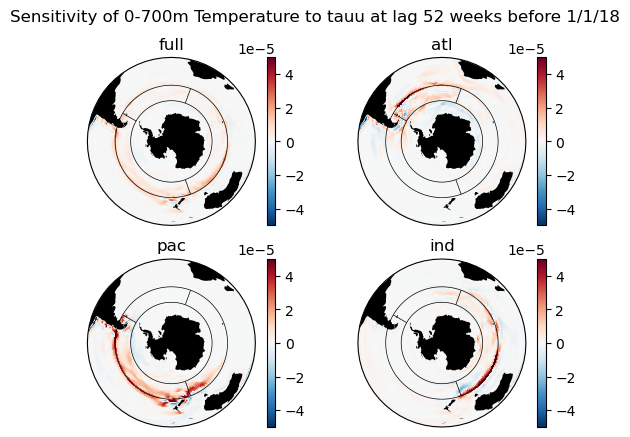

In [98]:
plot_var('tauu',52,5e-5)

()

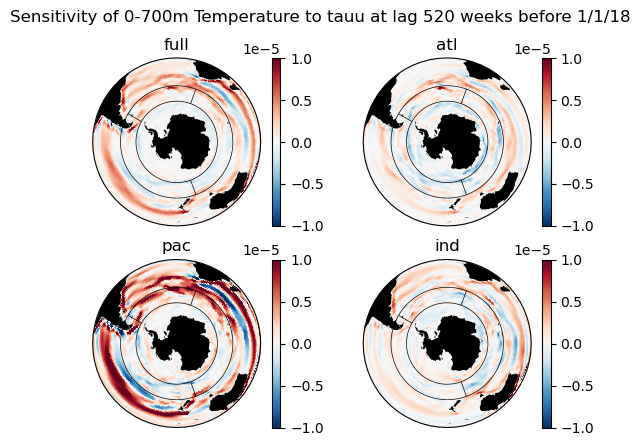

In [99]:
plot_var('tauu',520,1e-5)

()

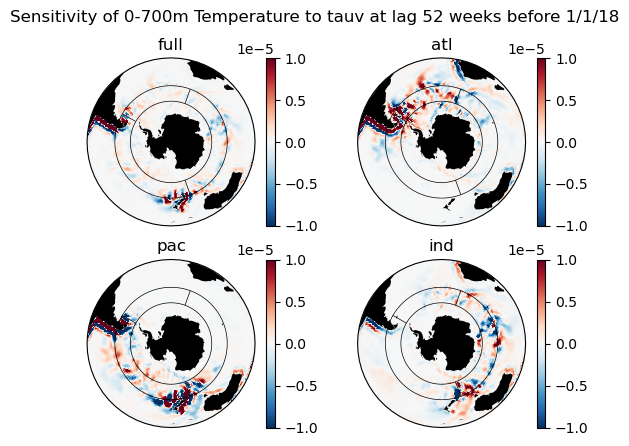

In [100]:
plot_var('tauv',52,1e-5)

()

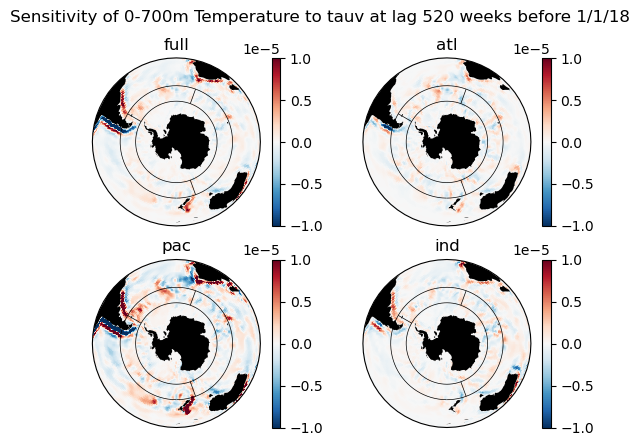

In [101]:
plot_var('tauv',520,1e-5)

In [102]:
ratio_ind_atl = 140./(140.+80.)
pmai_sensitivity = hc_arr[2] - (hc_arr[3] * ratio_ind_atl + hc_arr[1] * (1 - ratio_ind_atl))

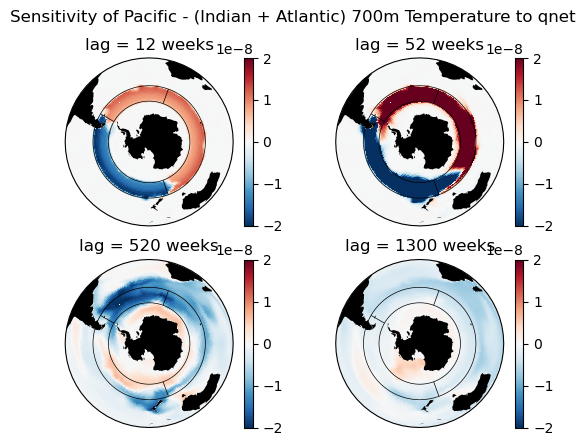

In [103]:
lags = [12,52,520,1300]
varname = 'qnet'
vmax= 2e-8

fig,axs = plt.subplots(2,2,subplot_kw={'projection':ccrs.Orthographic(0,-90)})
for i,ax in enumerate(axs.flatten()):
    im = ax.pcolormesh(pmai_sensitivity.lon,pmai_sensitivity.lat,
                  pmai_sensitivity[varname].sel({'lag':lags[i]}),
                  cmap='RdBu_r',
                  norm = colors.CenteredNorm(halfrange=vmax),
                    transform = ccrs.PlateCarree()
                 )
    plt.colorbar(im,ax=ax)
    ax.set_title(f'lag = {lags[i]} weeks')
    ax.add_feature(cfeature.LAND,facecolor='k',zorder=10)
    ax.vlines(lonboundaries,-61,-48,color='k',lw=0.5,transform=ccrs.PlateCarree())
    ax.plot(pmai_sensitivity.lon,(np.ones(360)*latboundaries[:,np.newaxis]).T,
            '-k',lw=0.5,transform=ccrs.PlateCarree())
plt.suptitle(f'Sensitivity of Pacific - (Indian + Atlantic) {depth}m Temperature to {varname}')
plt.savefig('figs/adj_pmai_qnet.png')

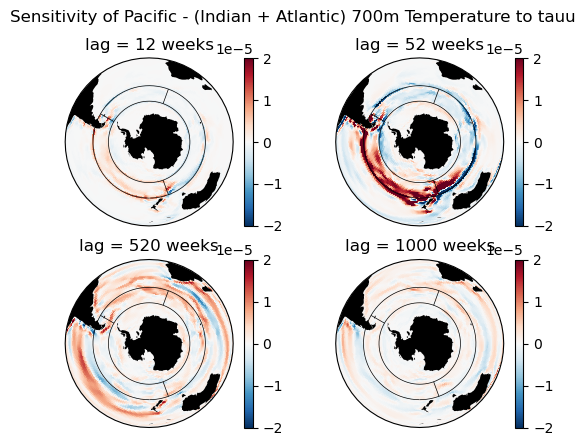

In [104]:
lags = [12,52,520,1000]
varname = 'tauu'
vmax= 2e-5

fig,axs = plt.subplots(2,2,subplot_kw={'projection':ccrs.Orthographic(0,-90)})
for i,ax in enumerate(axs.flatten()):
    im = ax.pcolormesh(pmai_sensitivity.lon,pmai_sensitivity.lat,
                  pmai_sensitivity[varname].sel({'lag':lags[i]}),
                  cmap='RdBu_r',
                  norm = colors.CenteredNorm(halfrange=vmax),
                    transform = ccrs.PlateCarree()
                 )
    plt.colorbar(im,ax=ax)
    ax.set_title(f'lag = {lags[i]} weeks')
    ax.add_feature(cfeature.LAND,facecolor='k',zorder=10)
    ax.vlines(lonboundaries,-61,-48,color='k',lw=0.5,transform=ccrs.PlateCarree())
    ax.plot(pmai_sensitivity.lon,(np.ones(360)*latboundaries[:,np.newaxis]).T,
            '-k',lw=0.5,transform=ccrs.PlateCarree())
plt.suptitle(f'Sensitivity of Pacific - (Indian + Atlantic) {depth}m Temperature to {varname}')
plt.savefig(f'figs/adj_pmai_{varname}.png')

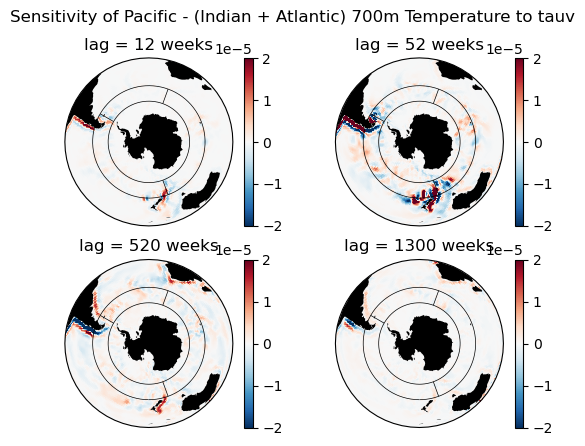

In [105]:
lags = [12,52,520,1300]
varname = 'tauv'
vmax= 2e-5

fig,axs = plt.subplots(2,2,subplot_kw={'projection':ccrs.Orthographic(0,-90)})
for i,ax in enumerate(axs.flatten()):
    im = ax.pcolormesh(pmai_sensitivity.lon,pmai_sensitivity.lat,
                  pmai_sensitivity[varname].sel({'lag':lags[i]}),
                  cmap='RdBu_r',
                  norm = colors.CenteredNorm(halfrange=vmax),
                    transform = ccrs.PlateCarree()
                 )
    plt.colorbar(im,ax=ax)
    ax.set_title(f'lag = {lags[i]} weeks')
    ax.add_feature(cfeature.LAND,facecolor='k',zorder=10)
    ax.vlines(lonboundaries,-61,-48,color='k',lw=0.5,transform=ccrs.PlateCarree())
    ax.plot(pmai_sensitivity.lon,(np.ones(360)*latboundaries[:,np.newaxis]).T,
            '-k',lw=0.5,transform=ccrs.PlateCarree())
plt.suptitle(f'Sensitivity of Pacific - (Indian + Atlantic) {depth}m Temperature to {varname}')
plt.savefig(f'figs/adj_pmai_{varname}.png')

In [108]:
!zip -r figs.zip figs

  adding: figs/ (stored 0%)
  adding: figs/adj_pmai_tauv.png (deflated 2%)
  adding: figs/adj_tauv_lag_520.png (deflated 2%)
  adding: figs/adj_pmai_tauu.png (deflated 2%)
  adding: figs/.ipynb_checkpoints/ (stored 0%)
  adding: figs/.ipynb_checkpoints/rms_tauu-checkpoint.png (deflated 3%)
  adding: figs/.ipynb_checkpoints/adj_pmai_tauv-checkpoint.png (deflated 2%)
  adding: figs/rms_qnet.png (deflated 3%)
  adding: figs/adj_pmai_qnet.png (deflated 2%)
  adding: figs/rms_tauu.png (deflated 3%)
  adding: figs/adj_qnet_lag_52.png (deflated 4%)
  adding: figs/adj_tauv_lag_52.png (deflated 2%)
  adding: figs/adj_qnet_lag_520.png (deflated 2%)
  adding: figs/adj_tauu_lag_52.png (deflated 3%)
  adding: figs/adj_tauu_lag_520.png (deflated 1%)
  adding: figs/rms_tauv.png (deflated 4%)
